## A Demonstration of the Harmenberg (2021) Aggregation Method

   - ["Aggregating heterogeneous-agent models with permanent income shocks"](https://doi.org/10.1016/j.jedc.2021.104185)

## Authors: [Christopher D. Carroll](http://www.econ2.jhu.edu/people/ccarroll/), [Mateo Velásquez-Giraldo](https://mv77.github.io/)

`# Set Up the Computational Environment: (in JupyterLab, click the dots)`

In [1]:
# Preliminaries
from HARK.ConsumptionSaving.ConsIndShockModel import (
    IndShockConsumerType
)

from HARK.ConsumptionSaving.tests.test_IndShockConsumerType import (
    dict_harmenberg    
)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Description of the problem

$\newcommand{\pLvl}{\mathbf{p}}$
$\newcommand{\mLvl}{\mathbf{m}}$
$\newcommand{\mNrm}{m}$
$\newcommand{\CLvl}{\mathbf{C}}$
$\newcommand{\MLvl}{\mathbf{M}}$
$\newcommand{\CLvlest}{\widehat{\CLvl}}$
$\newcommand{\MLvlest}{\widehat{\MLvl}}$
$\newcommand{\mpLvlDstn}{\mu}$
$\newcommand{\mWgtDstnMarg}{\tilde{\mu}^{m}}$
$\newcommand{\PermGroFac}{\pmb{\Phi}}$
$\newcommand{\PermShk}{\pmb{\Psi}}$
$\newcommand{\def}{:=}$
$\newcommand{\kernel}{\Lambda}$
$\newcommand{\pShkNeutDstn}{\tilde{f}_{\PermShk}}$
$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\cFunc}{\mathrm{c}}$
$\newcommand{\Rfree}{\mathsf{R}}$

Macroeconomic models with heterogeneous agents sometimes incorporate a microeconomic income process with a permanent component ($\pLvl_t$) that follows a geometric random walk. To find an aggregate characteristic of these economies such as aggregate consumption $\CLvl_t$, one must integrate over permanent income (and all the other relevant state variables):
\begin{equation*}
\CLvl_t = \int_{\pLvl} \int_{\mLvl} \mathrm{c}(\mLvl,\pLvl) \times f_t(\mLvl,\pLvl) \, d \mLvl\, d\pLvl, 
\end{equation*}
where $\mLvl$ denotes any other state variables that consumption might depend on, $\cFunc(\cdot,\cdot)$ is the individual consumption function, and $f_t(\cdot,\cdot)$ is the joint density function of permanent income and the other state variables at time $t$.

Under the usual assumption of Constant Relative Risk Aversion utility and standard assumptions about the budget constraint, [such models are homothetic](https://econ-ark.github.io/BufferStockTheory/BufferStockTheory3.html#The-Problem-Can-Be-Normalized-By-Permanent-Income). This means that for a state variable $\mLvl$ one can solve for a normalized policy function $\cFunc(\cdot)$ such that
\begin{equation*}
    \mathrm{c}(\mLvl,\pLvl) = \mathrm{c}\left(\mLvl/\pLvl\right)\times \pLvl 
\end{equation*}


In practice, this implies that one can defined a normalized state vector $\mNrm = \mLvl/\pLvl$ and solve for the normalized policy function. This eliminates one dimension of the optimization problem problem, $\pLvl$.

While convenient for the solution of the agents' optimization problem, homotheticity has not simplified our aggregation calculations as we still have

\begin{equation*}
\begin{split}
\CLvl_t =& \int \int \cFunc(\mLvl,\pLvl) \times f_t(\mLvl,\pLvl) \, d\mLvl\, d\pLvl\\
=& \int \int \cFunc\left(\frac{1}{\pLvl}\times \mLvl\right)\times \pLvl \times f_t(\mLvl,\pLvl) \, d\mLvl\, d\pLvl,
\end{split}
\end{equation*}

which depends on $\pLvl$.

To further complicate matters, we usually do not have analytical expressions for $\cFunc(\cdot)$ or $f_t(\mLvl,\pLvl)$. What we often do in practice is to simulate a population $I$ of agents for a large number of periods $T$ using the model's policy functions and transition equations. The result is a set of observations $\{\mLvl_{i,t},\pLvl_{i,t}\}_{i\in I, 0\leq t\leq T}$ which we then use to approximate
\begin{equation*}
\CLvl_t \approx \frac{1}{|I|}\sum_{i \in I} \cFunc\left(\mLvl_{i,t}/\pLvl_{i,t}\right)\times \pLvl_{i,t}. 
\end{equation*}

At least two features of the previous strategy are unpleasant:
- We have to simulate the distribution of permanent income, even though the model's solution does not depend on it.
- As a geometric random walk, permanent income might have an unbounded distribution. Since $\pLvl_{i,t}$ appears multiplicatively in our approximation, agents with high permanent incomes will be the most important in determining levels of aggregate variables. Therefore, it is important for our simulated population to achieve a good approximation of the distribution of permanent income among the small number of agents with very high permanent income, which will require us to use many agents (large $I$, requiring considerable computational resources).

[Harmenberg (2021)](https://www.sciencedirect.com/science/article/pii/S0165188921001202?via%3Dihub) solves both problems. His solution constructs a distribution $\tilde{f}(\cdot)$ of the normalized state vector that he calls **the permanent-income-weighted distribution** and which has the convenient property that
\begin{equation*}
\begin{split}
\CLvl_t =& \int \int \cFunc\left(\frac{1}{\pLvl}\times \mLvl\right)\times \pLvl \times f_t(\mLvl,\pLvl) \, d\mLvl\, d\pLvl\\
=& \int \cFunc\left(\mNrm\right) \times \tilde{f}(\mNrm) \, d\mNrm.
\end{split}
\end{equation*}

Therefore, his solution allows us to calculate aggregate variables without the need to keep track of the distribution of permanent income. Additionally, the method eliminates the issue of a small number of agents in the tail having an outsized influence in our approximation and this makes it much more precise.

This notebook briefly describes Harmenberg's method and demonstrates its implementation in the HARK toolkit.

# Description of the method

To illustrate Harmenberg's idea, consider a [buffer stock saving](https://econ-ark.github.io/BufferStockTheory) model in which:
- The individual agent's problem has two state variables:
    - Market resources $\mLvl_{i,t}$.
    - Permanent income $\pLvl_{i,t}$.
    
- The agent's problem is homothetic in permanent income, so that we can define $m_t = \mLvl_t/\pLvl_t$ and find a normalized policy function $\cFunc(\cdot)$ such that
\begin{equation*}
\cFunc(\mNrm) \times \pLvl_t = \cFunc(\mLvl_t, \pLvl_t) \,\,\qquad \forall(\mLvl_t, \pLvl_t)
\end{equation*}
where $\cFunc(\cdot,\cdot)$ is the optimal consumption function.

- $\pLvl_t$ evolves according to $$\pLvl_{t+1} = \PermGroFac \PermShk_{t+1} \pLvl_t,$$ where $\PermShk_{t+1}$ is a shock with density function $f_{\PermShk}(\cdot)$ satisfying $\Ex_t[\PermShk_{t+1}] = 1$.

To compute aggregate consumption $\CLvl_t$ in this model, we would follow the approach from above
\begin{equation*}
\CLvl_t = \int \int \cFunc(\mNrm)\times\pLvl \times \mpLvlDstn_t(\mNrm,\pLvl) \, d\mNrm \, d\pLvl,
\end{equation*}
where $\mpLvlDstn_t(\mNrm,\pLvl)$ is the measure of agents with normalized resources $\mNrm$ and permanent income $\pLvl$.

## First insight

The first of Harmenberg's insights is that the previous integral can be rearranged as
\begin{equation*}
\CLvl_t = \int_{\pLvl} \cFunc(\mNrm)\left(\int \pLvl \times \mpLvlDstn_t(\mNrm,\pLvl) \, d\pLvl\right) \, d\mNrm.
\end{equation*}
The inner integral, $\int_{\pLvl} \pLvl \times \mpLvlDstn_t(\mNrm,\pLvl) \, d\pLvl$, is a function of $\mNrm$ and it measures *the total amount of permanent income accruing to agents with normalized market resources of* $\mNrm$. De-trending this object by the deterministic component of growth in permanent income $\PermGroFac$, Harmenberg defines the *permanent-income-weighted distribution* $\mWgtDstnMarg(\cdot)$ as

\begin{equation*}
\mWgtDstnMarg_{t}(\mNrm) \def \PermGroFac^{-t}\int_{\pLvl} \pLvl \times \mpLvlDstn_t(\mNrm,\pLvl) \, d\pLvl.
\end{equation*}


The definition allows us to rewrite
\begin{equation}\label{eq:aggC}
\CLvl_{t} = \PermGroFac^t \int_{m} \cFunc(\mNrm) \times \mWgtDstnMarg_t(\mNrm) \, dm.
\end{equation}

There are no computational advances yet: We have merely hidden the joint distribution of $(\pLvl,\mNrm)$ inside the $\mWgtDstnMarg$ object we have defined. This helps us notice that $\mWgtDstnMarg$ is the only object besides the solution that we need in order to compute aggregate consumption. But we still have no practial way of computing or approximating $\mWgtDstnMarg$.

## Second insight

Harmenberg's second insight produces a simple way of generating simulated counterparts of $\mWgtDstnMarg$ without having to simulate permanent incomes.

We start with the density function of $\mNrm_{t+1}$ given $\mNrm_t$ and $\PermShk_{t+1}$, $\kernel(\mNrm_{t+1}|\mNrm_t,\PermShk_{t+1})$. This density will depend on the model's transition equations and draws of random variables like transitory shocks to income in $t+1$ or random returns to savings between $t$ and $t+1$. If we can simulate those things, then we can sample from $\kernel(\cdot|\mNrm_t,\PermShk_{t+1})$.

Harmenberg shows that
\begin{equation}\label{eq:transition}
\texttt{transition:    }\mWgtDstnMarg_{t+1}(\mNrm_{t+1}) = \int \kernel(\mNrm_{t+1}|\mNrm_t, \PermShk_t) \pShkNeutDstn(\PermShk_{t+1}) \mWgtDstnMarg_t(\mNrm_t)\, d\mNrm_t\, d\PermShk_{t+1},
\end{equation}
where $\pShkNeutDstn$ is an altered density function for the permanent income shocks $\PermShk$, which he calls the *permanent-income-neutral* measure, and which relates to the original density $f_{\PermShk}$ through $$\pShkNeutDstn(\PermShk_{t+1})\def \PermShk_{t+1}f_{\PermShk}(\PermShk_{t+1})\,\,\, \forall \PermShk_{t+1}.$$

What's remarkable about this equation is that it gives us a way to obtain a distribution $\mWgtDstnMarg_{t+1}$ from $\mWgtDstnMarg_t$:
- Start with a population whose $\mNrm$ is distributed according to $\mWgtDstnMarg_t$.
- Give that population permanent income shocks with distribution $\pShkNeutDstn$.
- Apply the transition equations and other shocks of the model to obtain $\mNrm_{t+1}$ from $\mNrm_{t}$ and $\PermShk_{t+1}$ for every agent.
- The distribution of $\mNrm$ across the resulting population will be $\mWgtDstnMarg_{t+1}$.

Notice that the only change in these steps from what how we would usually simulate the model is that we now draw permanent income shocks from $\pShkNeutDstn$ instead of $f_{\PermShk}$. Therefore, with this procedure we can approximate $\mWgtDstnMarg_t$ and compute aggregates using formulas like the equation `transition`, all without tracking permanent income and with few changes to the code we use to simulate the model.

# Harmenberg's method in HARK

Harmenberg's method for simulating under the permanent-income-neutral measure is available in [HARK's `IndShockConsumerType` class](https://github.com/econ-ark/HARK/blob/master/HARK/ConsumptionSaving/ConsIndShockModel.py) and the (many) models that inherit its income process, such as [`PortfolioConsumerType`](https://github.com/econ-ark/HARK/blob/master/HARK/ConsumptionSaving/ConsPortfolioModel.py).

As the cell below illustrates, using Harmenberg's method in [HARK](https://github.com/econ-ark/HARK) simply requires setting an agent's property `agent.neutral_measure = True` and then computing the discrete approximation to the income process. After these steps, `agent.simulate` will simulate the model using Harmenberg's permanent-income-neutral measure.

`# Implementation in HARK:`

In [2]:
# Create an infinite horizon agent with the default parametrization
example = IndShockConsumerType(**dict_harmenberg, verbose = 0)
example.cycles = 0

# Solve for the consumption function
example.solve()

# Simulation under the base measure
example.initialize_sim()


(quietly=False and messaging_level < logging.WARNING, so some model information is provided below):

The model has the following parameter values:

	DiscFac: 0.9735
	LivPrb: 0.99375
	CRRA: 2
	Rfree: 1.0098534065489688
	PermGroFac: 1.0
	IncShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f80282aa9a0>
	PermShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f8028272940>
	TranShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f8068c77490>
	BoroCnstArt: 0.0
	MaxKinks: None
	solverType: HARK
	solveMethod: EGM
	eventTiming: EOP
	horizon: infinite
	args: ()

The model's transition equations are:

chosen_to_next_choice step:
	kNrm = aNrm
	RNrm = Rfree / (PermGroFac * PermShk)
	bNrm = kNrm * RNrm
	yNrm = TranShk
	mNrm = bNrm + yNrm

choice_to_chosen step:
	aNrm = mNrm - cNrm


Because messaging_level is >= logging.INFO, infinite horizon conditions are reported below:


The Absolute Patience Factor, APFac=0.98841 satisfies the Absolute Impatience Condition (AIC

............................................................................................................................................................


(quietly=False and messaging_level < logging.WARNING, so some model information is provided below):

The model has the following parameter values:

	DiscFac: 0.9735
	LivPrb: 0.99375
	CRRA: 2
	Rfree: 1.0098534065489688
	PermGroFac: 1.0
	IncShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f80282aa9a0>
	PermShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f8028272940>
	TranShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f8068c77490>
	BoroCnstArt: 0.0
	MaxKinks: None
	solverType: HARK
	solveMethod: EGM
	eventTiming: EOP
	horizon: infinite
	args: ()

The model's transition equations are:

chosen_to_next_choice step:
	kNrm = aNrm
	RNrm = Rfree / (PermGroFac * PermShk)
	bNrm = kNrm * RNrm
	yNrm = TranShk
	mNrm = bNrm + yNrm

choice_to_chosen step:
	aNrm = mNrm - cNrm


Because messaging_level is >= logging.INFO, infinite horizon conditions are reported below:


The Absolute Patience Factor, APFac=0.98841 satisfies the Absolute Impatience Condition (AIC

.....

In [3]:
example.simulate()

# Harmenberg permanent-income-neutral simulation

# Change the income process to use the neutral measure
example.neutral_measure = True
example.update_income_process()
example.initialize_sim()
example.simulate()

{}

All we had to do differently to simulate using the permanent-income-neutral measure was to set the agent's property `neutral_measure=True`.

This is implemented when the function `update_income_process` re-constructs the agent's income process. The specific lines that achieve the change of measure in HARK are in [this link](https://github.com/econ-ark/HARK/blob/760df611a6ec2ff147d00b7d866dbab6fc4e18a1/HARK/ConsumptionSaving/ConsIndShockModel.py#L2734-L2735), or reproduced here:

```python
if self.neutral_measure == True:
    PermShkDstn_t.pmf = PermShkDstn_t.X*PermShkDstn_t.pmf
```

Simple!

# The eficiency gain from using Harmenberg's method

To demonstrate the gain in efficiency from using Harmenberg's method, we will set up the following experiment.

Consider an economy populated by [Buffer-Stock](https://econ-ark.github.io/BufferStockTheory/) savers, whose individual-level state variables are market resources $\mLvl_t$ and permanent income $\pLvl_t$. Such agents have a [homothetic consumption function](https://econ-ark.github.io/BufferStockTheory/#The-Problem-Can-Be-Normalized-By-Permanent-Income), so that we can define normalized market resources $\mNrm_t \def \mLvl_t / \pLvl_t$, solve for a normalized consumption function $\cFunc(\cdot)$, and express the consumption function as $\cFunc(\mLvl,\pLvl) = \cFunc(\mNrm)\times\pLvl$.

Assume further that mortality, impatience, and permanent income growth are such that the economy converges to stable joint distribution of $\mNrm$ and $\pLvl$ characterized by the density function $f(\cdot,\cdot)$. Under these conditions, define the stable level of aggregate market resources and consumption as
\begin{equation}
    \MLvl \def \int \int \mNrm \times \pLvl \times f(\mNrm, \pLvl)\,d\mNrm \,d\pLvl, \,\,\,    \CLvl \def \int \int \cFunc(\mNrm) \times \pLvl \times f(\mNrm, \pLvl)\,d\mNrm \,d\pLvl.
\end{equation}

If we could simulate the economy with a continuum of agents we would find that, over time, our estimate of aggregate market resources $\MLvlest_t$ would converge to $\MLvl$ and $\CLvlest_t$ would converge to $\CLvl$. Therefore, if we computed our aggregate estimates at different periods in time we would find them to be close:
\begin{equation}
    \MLvlest_t \approx \MLvlest_{t+n} \approx \MLvl \,\,
    \text{and} \,\,
    \CLvlest_t \approx \CLvlest_{t+n} \approx \CLvl, \,\,
    \text{for } n>0 \text{ and } t \text{ large enough}.
\end{equation}

In practice, however, we rely on approximations using a finite number of agents $I$. Our estimates of aggregate market resources and consumption at time $t$ are
\begin{equation}
\MLvlest_t \def \frac{1}{I} \sum_{i=1}^{I} m_{i,t}\times\pLvl_{i,t}, \,\,\, \CLvlest_t \def \frac{1}{I} \sum_{i=1}^{I} \cFunc(m_{i,t})\times\pLvl_{i,t},
\end{equation}

under the basic simulation strategy or

\begin{equation}
\MLvlest_t \def \frac{1}{I} \sum_{i=1}^{I} \tilde{m}_{i,t}, \,\,\, \CLvlest_t \def \frac{1}{I} \sum_{i=1}^{I} \cFunc(\tilde{m}_{i,t}),
\end{equation}

if we use Harmenberg's method to simulate the distribution of normalized market resources under the permanent-income neutral measure.

If we do not use enough agents, our distributions of agents over state variables will be noisy at approximating their continuous counterparts. Additionally, they will depend on the sequences of shocks that the agents receive. With a finite sample, the stochasticity of the draws will cause fluctuations in $\MLvlest_t$ and $\CLvlest_t$. Therefore an informal way to measure the precision of our approximations is to examine the amplitude of these fluctuations.

First, some setup.
1. Simulate the economy for a sufficiently long "burn in" time $T_0$.
2. Sample our aggregate estimates at regular intervals after $T_0$. Letting the sampling times be $\mathcal{T}\def \{T_0 + \Delta t\times n\}_{n=0,1,...,N}$, obtain $\{\MLvlest_t\}_{t\in\mathcal{T}}$ and $\{\CLvlest_t\}_{t\in\mathcal{T}}$.
3. Compute the variance of approximation samples $\text{Var}\left(\{\MLvlest_t\}_{t\in\mathcal{T}}\right)$ and $\text{Var}\left(\{\CLvlest_t\}_{t\in\mathcal{T}}\right)$.
    - Other measures of uncertainty (like standard deviation) could also be computed
    - But variance is the natural choice [because it is closely related to expected welfare](http://www.econ2.jhu.edu/people/ccarroll/papers/candcwithstickye/#Utility-Costs-Of-Sticky-Expectations)

We will now perform exactly this exercise, examining the fluctuations in aggregates when they are approximated using the basic simulation strategy and Harmenberg's permanent-income-neutral measure. Since each approximation can be made arbitrarily good by increasing the number of agents it uses, we will examine the variances of aggregates for various sample sizes.

`# Setup computational environment:`

In [4]:
# How long to run the economies without sampling? T_0
burnin = 2000
# Fixed intervals between sampling aggregates, Δt
sample_every = 50
# How many times to sample the aggregates? n
n_sample = 100

# Create a vector with all the times at which we'll sample
sample_periods = np.arange(start=burnin,
                           stop = burnin+sample_every*n_sample,
                           step = sample_every, dtype = int)

# Maximum number of aggents that we will use for our approximations
max_agents = 10000

`# Define tool to calculate summary statistics:`

In [5]:
# Now create a function that takes HARK's simulation output
# and computes all the summary statistics we need

def sumstats(sims, sample_periods):
    
    # sims will be an array in the shape of hark's
    # agent.history elements
    
    # Columns are different agents and rows are different times.
    # Subset the times at which we'll sample and transpose.
    samples = pd.DataFrame(sims[sample_periods,].T)
    
    # Get rolling averages over agents. This will tell us
    # What our aggregate estimate would be if we had each possible
    # sample size
    avgs = samples.expanding(1).mean()
    
    # Now get the mean and standard deviations across time with
    # every number of agents
    means = avgs.mean(axis = 1)
    stds = avgs.std(axis = 1)
    
    # Also return the full sampl on the last simulation period
    return {'means':  means, 'stds': stds, 'dist_last': sims[-1,]}

We now configure and solve a buffer-stock agent with a default parametrization.

In [6]:
# Create and solve agent
dict_harmenberg.update(
    {'T_sim': max(sample_periods)+1, 'AgentCount': max_agents,
     'track_vars': [ 'mNrm','cNrm','pLvl']}
)

example = IndShockConsumerType(**dict_harmenberg, verbose = 0)
example.cycles = 0
example.solve()


(quietly=False and messaging_level < logging.WARNING, so some model information is provided below):

The model has the following parameter values:

	DiscFac: 0.9735
	LivPrb: 0.99375
	CRRA: 2
	Rfree: 1.0098534065489688
	PermGroFac: 1.0
	IncShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f808898b550>
	PermShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f8068c77b50>
	TranShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f80291edd30>
	BoroCnstArt: 0.0
	MaxKinks: None
	solverType: HARK
	solveMethod: EGM
	eventTiming: EOP
	horizon: infinite
	args: ()

The model's transition equations are:

chosen_to_next_choice step:
	kNrm = aNrm
	RNrm = Rfree / (PermGroFac * PermShk)
	bNrm = kNrm * RNrm
	yNrm = TranShk
	mNrm = bNrm + yNrm

choice_to_chosen step:
	aNrm = mNrm - cNrm


Because messaging_level is >= logging.INFO, infinite horizon conditions are reported below:


The Absolute Patience Factor, APFac=0.98841 satisfies the Absolute Impatience Condition (AIC

.............................................................................................................................................................


(quietly=False and messaging_level < logging.WARNING, so some model information is provided below):

The model has the following parameter values:

	DiscFac: 0.9735
	LivPrb: 0.99375
	CRRA: 2
	Rfree: 1.0098534065489688
	PermGroFac: 1.0
	IncShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f808898b550>
	PermShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f8068c77b50>
	TranShkDstn: <HARK.distribution.DiscreteDistribution object at 0x7f80291edd30>
	BoroCnstArt: 0.0
	MaxKinks: None
	solverType: HARK
	solveMethod: EGM
	eventTiming: EOP
	horizon: infinite
	args: ()

The model's transition equations are:

chosen_to_next_choice step:
	kNrm = aNrm
	RNrm = Rfree / (PermGroFac * PermShk)
	bNrm = kNrm * RNrm
	yNrm = TranShk
	mNrm = bNrm + yNrm

choice_to_chosen step:
	aNrm = mNrm - cNrm


Because messaging_level is >= logging.INFO, infinite horizon conditions are reported below:


The Absolute Patience Factor, APFac=0.98841 satisfies the Absolute Impatience Condition (AIC

....

Under the basic simulation strategy, we have to de-normalize market resources and consumption multiplying them by permanent income. Only then we construct our statistics of interest.

Note that our time-sampling strategy requires that, after enough time has passed, the economy settles on a stable distribution of its agents across states. How can we know this will be the case? [Szeidl (2013)](http://www.personal.ceu.hu/staff/Adam_Szeidl/papers/invariant.pdf) and [Harmenberg (2021)](https://www.sciencedirect.com/science/article/pii/S0165188921001202?via%3Dihub) provide conditions that can give us some reassurance.$\newcommand{\Rfree}{\mathsf{R}}$

1. [Szeidl (2013)](http://www.personal.ceu.hu/staff/Adam_Szeidl/papers/invariant.pdf) shows that if $$\log \left[\frac{(\Rfree\beta)^{1/\rho}}{\PermGroFac}
\right] < \Ex[\log \PermShk],$$ then there is a stable invariant distribution of normalized market resources $\mNrm$.
2. [Harmenberg (2021)](https://www.sciencedirect.com/science/article/pii/S0165188921001202?via%3Dihub) repurposes the Szeidl proof to argue that if the same condition is satisfied when the expectation is taken with respect to the permanent-income-neutral measure ($\pShkNeutDstn$), then there is a stable invariant permanent-income-weighted distribution ($\mWgtDstnMarg$)

We now check both conditions with our parametrization.

In [7]:
from HARK.distribution import calc_expectation

thorn_G = (example.Rfree * example.DiscFac) ** (1/example.CRRA) / example.PermGroFac[0]
GPFacRaw = example.solution[0].Bilt.GPFacRaw
GPFacRaw-thorn_G

-0.003103325629330689

In [8]:
e_log_psi_base = calc_expectation(example.PermShkDstn[0], func = lambda x: np.log(x))
# E_pin[g(eta)] = E_base[eta*g(eta)]
e_log_psi_pin = calc_expectation(example.PermShkDstn[0], func = lambda x: x*np.log(x))

szeidl_cond = np.log(thorn_G) < e_log_psi_base
harmen_cond = np.log(thorn_G) < e_log_psi_pin

if szeidl_cond:
    print("Szeidl's condition is satisfied, there is a stable invariant distribution of normalized market resources")
else:
    print("Warning: Szeidl's condition is not satisfied")
if harmen_cond:
    print("Harmenberg's condition is satisfied, there is a stable invariant permanent-income-weighted distribution")
else:
    print("Warning: Harmenberg's condition is not satisfied")

Szeidl's condition is satisfied, there is a stable invariant distribution of normalized market resources
Harmenberg's condition is satisfied, there is a stable invariant permanent-income-weighted distribution


Knowing that the conditions are satisfied, we are ready to perform our experiments.

First, we simulate using the traditional approach.

In [9]:
# Base simulation
example.initialize_sim()
example.simulate()

M_base = sumstats(example.history['mNrm'] * example.history['pLvl'],
                  sample_periods)
m_base = sumstats(example.history['mNrm'], sample_periods)
C_base = sumstats(example.history['cNrm'] * example.history['pLvl'],
                  sample_periods)

Update and simulate using Harmenberg's strategy. This time, not multiplying by permanent income.

In [10]:
# Harmenberg PIN simulation
example.neutral_measure = True
example.update_income_process()
example.track_vars = [ 'mNrm','cNrm']
example.initialize_sim()
example.simulate()

M_pin = sumstats(example.history['mNrm'], sample_periods)
C_pin = sumstats(example.history['cNrm'], sample_periods)

We can now compare the two methods my plotting our measure of precision for different numbers of simulated agents.

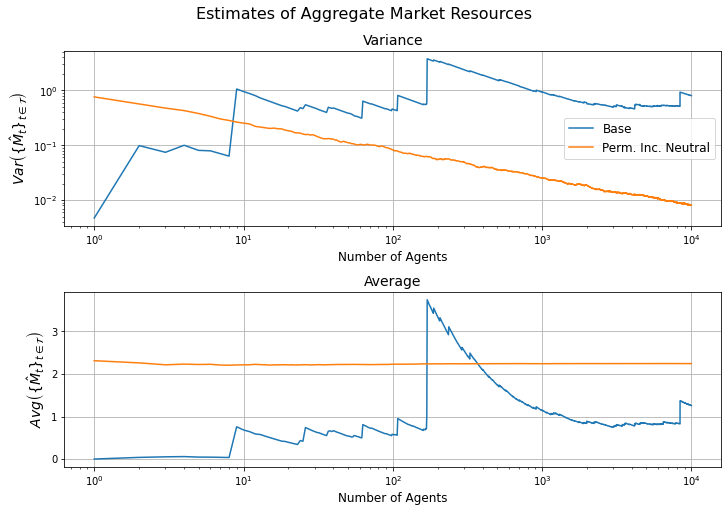

In [11]:
# Plots
nagents = np.arange(1,max_agents+1,1)

# Market resources
fig, axs = plt.subplots(2, figsize = (10,7), constrained_layout=True)

fig.suptitle('Estimates of Aggregate Market Resources', fontsize=16)
axs[0].plot(nagents, M_base['stds'], label = 'Base')
axs[0].plot(nagents, M_pin['stds'], label = 'Perm. Inc. Neutral')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_title('Variance', fontsize=14)
axs[0].set_ylabel(r'$Var\left(\{\hat{M}_t\}_{t\in\mathcal{T}}\right)$', fontsize = 14)
axs[0].set_xlabel('Number of Agents', fontsize=12)
axs[0].grid()
axs[0].legend(fontsize=12)

axs[1].plot(nagents, M_base['means'], label = 'Base')
axs[1].plot(nagents, M_pin['means'], label = 'Perm. Inc. Neutral')
axs[1].set_xscale('log')
axs[1].set_title('Average', fontsize=14)
axs[1].set_ylabel(r'$Avg\left(\{\hat{M}_t\}_{t\in\mathcal{T}}\right)$', fontsize=14)
axs[1].set_xlabel('Number of Agents', fontsize=12)
axs[1].grid()
plt.show()

The previous plot highlights the gain in efficiency from Harmenberg's method: it attains any given level of precission ($\text{Var}\left(\{\MLvlest_t\}_{t\in\mathcal{T}}\right)$) with roughly **one tenth** of the agents needed by the standard method to achieve that same level.

We now examine consumption.

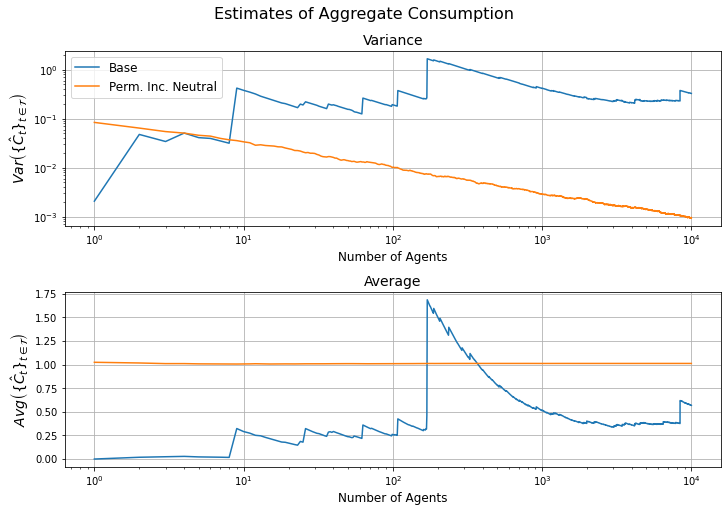

In [12]:
# Consumption
fig, axs = plt.subplots(2, figsize = (10,7), constrained_layout=True)

fig.suptitle('Estimates of Aggregate Consumption', fontsize=16)
axs[0].plot(nagents, C_base['stds'], label = 'Base')
axs[0].plot(nagents, C_pin['stds'], label = 'Perm. Inc. Neutral')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_title('Variance', fontsize=14)
axs[0].set_ylabel(r'$Var\left(\{\hat{C}_t\}_{t\in\mathcal{T}}\right)$', fontsize = 14)
axs[0].set_xlabel('Number of Agents', fontsize=12)
axs[0].grid()
axs[0].legend(fontsize=12)

axs[1].plot(nagents, C_base['means'], label = 'Base')
axs[1].plot(nagents, C_pin['means'], label = 'Perm. Inc. Neutral')
axs[1].set_xscale('log')
axs[1].set_title('Average', fontsize=14)
axs[1].set_ylabel(r'$Avg\left(\{\hat{C}_t\}_{t\in\mathcal{T}}\right)$', fontsize=14)
axs[1].set_xlabel('Number of Agents', fontsize=12)
axs[1].grid()
plt.show()

The variance plot shows that the efficiency gains are even greater for consumption: Harmenberg's method requires roughly **one-hundredth** of the agents that the standard method would require for a given precision, and at a fixed number of agents it is **ten times more precise**!

# Permanent-income-weighted measure and market-resources distribution are different things!

We have learned that 
\begin{equation}
\MLvl_t = \int_{\mNrm} \int_{\pLvl} \mNrm \times \pLvl \times \mpLvlDstn_t(\mNrm,\pLvl) \, d\pLvl \, d\mNrm = \PermGroFac^t \int \mNrm \times \mWgtDstnMarg_t(\mNrm) \, d\mNrm.
\end{equation}
This equivalence might lead us to thing that, in our simulations, $\mNrm$ under the permanent-income-weighted measure ($\mWgtDstnMarg$) is equivalent to $\mLvl = \mNrm\times \pLvl$ under the base measure. However, **this is not the case**: $\mWgtDstnMarg_t(x)$ is the total (de-trended) amount of permanent income earned by people with normalized resources $\mNrm = x$, **not** the measure of agents with non-normalized resources $\mLvl = x$.

To visualize this point, it suffices to examine our simulations. We now plot density estimates of $\mNrm$ in the permanent-income-neutral simulation and $\mNrm \times \pLvl$ under the base simulation. It is clear that the densities are not the same!

(0.0, 10.0)

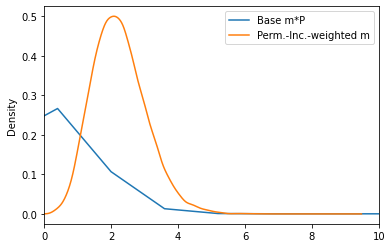

In [13]:
mdists = pd.DataFrame({'Base m*P': M_base['dist_last'],
                       'Perm.-Inc.-weighted m': M_pin['dist_last']})

mdists.plot.kde()
plt.xlim([0,10])